<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Regularization

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives 
- Learn about regularization for regression models.
- Understand how regularization modifies the loss function.
- Understand the effect of regularization on coefficients.
- Look at the differences between the lasso, ridge, and elastic net.
- Implement and visualize the penalties using scikit-learn.

### Lesson Guide
- [Overview of Regularization](#intro)
- [Review: the Least Squares Loss Function](#lsq-loss)
- [The Ridge Penalty](#ridge)
- [The Lasso Penalty](#lasso)
- [The Elastic Net Penalty](#elastic-net)
- [The Effect of Regularization](#effect)
- [When Standardizing Predictors are Required](#standardization)
- [Visualizing the Ridge](#viz-ridge)
- [Visualizing the Lasso](#viz-lasso)
- [Visualizing the Elastic Net](#viz-elastic-net)
- [Model Performance With Complex Predictor Matrix Using Regularization](#model-performance)

In [14]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id='intro'></a>

## Overview of Regularization

---

The goal of "regularizing" regression models is to structurally prevent overfitting by imposing a penalty on the coefficients of the model.

Regularization methods like the ridge and the lasso add this additional "penalty" on the size of coefficients to the loss function. When the loss function is minimized, this additional component is added to the residual sum of squares.

In other words, the minimization balances the error between predictions and true values and the size of the coefficients. 

The most common types of regularization are the **lasso** and the **ridge**. A combination of the two is called the **elastic net**. In this lesson, we'll take a look at the mathematics of regularization and the effect penalties have on model fits.


<a id='lsq-loss'></a>

## Review: Least Squares Loss Function

---

Ordinary least squares regression minimizes the residual sum of squares (RSS) to fit the data:

### $$ \text{minimize:}\; RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 $$

Where our model predictions for $y$ are based on the sum of the $beta_0$ intercept and the products of $\beta_i$ with $x_i$.

Alternatively, in matrix notation using predictor matrix $X$, residual errors $\epsilon$, and vector of beta coefficients $\beta$:

### $$ \text{minimize:}\; RSS = \epsilon' \epsilon = (y - \beta X)' (y - \beta X) $$

<a id='ridge'></a>

## The Ridge Penalty

---

Ridge regression adds the sum of the squared (non-intercept!) $\beta$ values to the loss function:

### $$ \text{minimize:}\; RSS+Ridge = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_2\sum_{j=1}^p \beta_j^2$$

**Where:**

$\beta_j^2$ is the squared coefficient for variable $x_j$.

$\sum_{j=1}^n \beta_ij^2$ is the sum of these squared coefficients for every variable in the model. This does **not** include the intercept $\beta_0$.

$\lambda_2$ is a constant for the _strength_ of the regularization parameter. The higher the value, the greater the impact of this new component in the loss function. If the value was zero, we would revert back to just the least squares loss function. If the value was a billion, however, the residual sum of squares component would have a much smaller effect on the loss/cost than the regularization term.

With the penalty added, the RSS is referred to as the **penalized residual sum of squares (PRSS)**. In matrix format, the ridge PRSS is:

### $$ \text{Ridge PRSS} = (y - \beta X)' (y - \beta X) + \lambda_2 \; ||\beta||^2 $$

Where $||\beta||_2^2$ is the squared norm of the coefficient vector (again, excluding intercept).

To solve for the coefficients, the derivative we set to zero becomes:

### $$ \frac{\partial PRSS}{\partial \beta} = -2X'y + 2X'X\beta + 2\lambda_2 \beta$$

And the solution to the beta coefficient vector is:

### $$ \text{Ridge }  \beta = (X'X + \lambda_2I)^{-1}X'y $$

<a id='lasso'></a>

## The Lasso Penalty

---

Lasso regression takes a different approach. Instead of adding the sum of squared $\beta$ coefficients to the RSS, it adds the sum of the absolute values of the $\beta$ coefficients:

### $$ \text{minimize:}\; RSS + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j|$$

**Where:**

$|\beta_j|$ is the absolute value of the $\beta$ coefficient for variable $x_j$.

$\lambda_1$ is again the strength of the regularization penalty component in the loss function. In lasso regression, the $\lambda_1$ is denoted with a 1, whereas in ridge regression it is denoted with a 2.


**In matrix format, the lasso PRSS is:**

### $$ \text{Lasso PRSS} = (y - \beta X)' (y - \beta X) + \lambda_1 \; ||\beta|| $$

Unlike the ridge, however, there is no closed-form solution for the lasso's beta coefficients.

<a id='elastic-net'></a>

## Elastic Net Penalty

---

Elastic net is simply a combination of the lasso and ridge regularizations. It adds *both* penalties to the loss function:

### $$ \text{minimize:}\; RSS + Ridge + Lasso = \sum_{i=1}^n \left(y_i - \left(\beta_0 + \sum_{j=1}^p\beta_j x_j\right)\right)^2 + \lambda_1\sum_{j=1}^p |\beta_j| + \lambda_2\sum_{j=1}^p \beta_j^2$$

In the elastic net, the effect of the ridge versus the lasso is balanced by the two $\lambda_1$ parameters. 

<a id='effect'></a>

## What Are the Effects of Regularization?

---

**To demonstrate, we will be using a data set on wine quality.**

It's important to note that there is **multicollinearity** in the data set, which means there is a high correlation between the predictor variables in your model. Because of this, we might choose to use regularization.

**Multicollinearity can lead to a variety of problems and complications, including:**

1) The effects of predictor variables estimated by your regression will depend on the other variables included in your model.

2) Predictors can have very different effects depending on the observations in your sample, and small changes in samples can result in very different estimated effects.

3) With high multicollinearity, the inverse matrix the computer calculates may not be accurate.

4) When predictors are strongly correlated, it's not possible for one variable to change without a conditional change in another variable. Therefore, we can no longer interpret a coefficient on a variable as the effect on the target of a one-unit increase in that variable holding the other variables constant.

The ridge is best suited to deal with multicollinearity. Lasso also handles multicollinearity between variables but in a more extreme way (i.e., it "zeroes out" the less-effective variable).

The lasso is particularly useful when you have redundant or unimportant variables. If you have 1,000 variables in a data set, the lasso can automatically perform "feature selection" by forcing coefficients to be zero.

### Load the Wine `.csv`

This version has red and white wines concatenated together and tagged with a binary 1,0 indicator (1 is red wine). There are many other variables purportedly related to the rated quality of the wine.

In [15]:
wine = pd.read_csv('./datasets/winequality_merged.csv')

# Replace spaces in column names and convert all columns to lowercase.
wine.columns = [x.lower().replace(' ','_') for x in wine.columns]

In [16]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


**Look at the correlation between variables.**

In [17]:
wine_corr = wine.corr()
wine_corr

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
fixed_acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,0.486740
volatile_acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,0.653036
citric_acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,-0.187397
residual_sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,-0.348821
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,0.512678
free_sulfur_dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,-0.471644
total_sulfur_dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,-0.700357
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,0.390645
ph,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,0.329129
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,0.487218


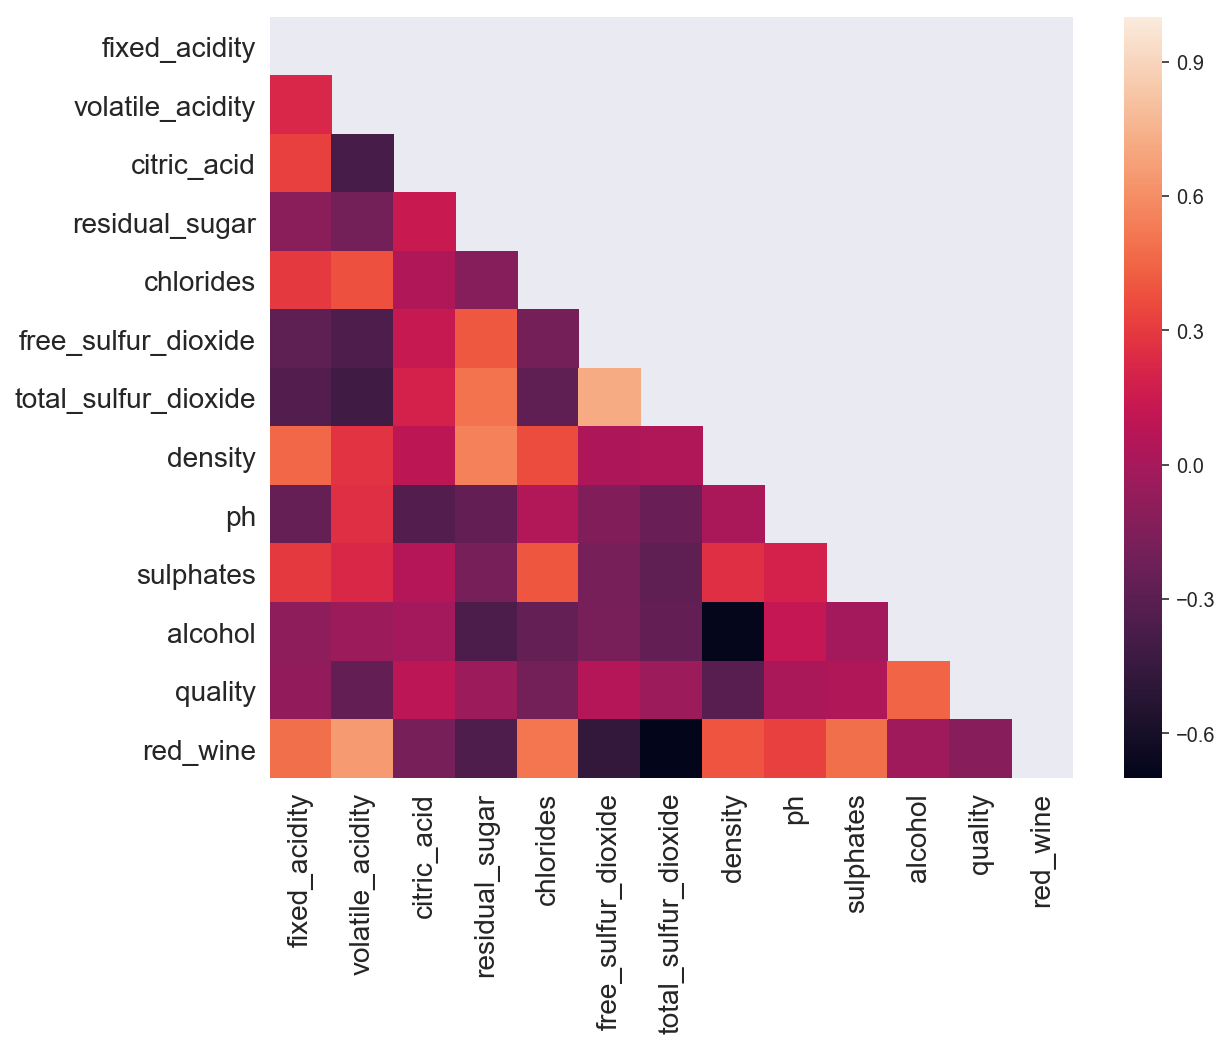

In [18]:
# Set the default matplotlib figure size to 7x7.
fix, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from Seaborn's example gallery).
mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with Seaborn.
# Assign the matplotlib axis the function returns. This will allow us to resize the labels.
ax = sns.heatmap(wine_corr, mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<a id='standardization'></a>

## When Standardizing Predictors Is Required

---

When using lasso and ridge, always standardize the predictor columns before constructing the models — even the dummy-coded categorical variables.

We define our target variable and normalize the columns that are not the target below.

Recall the equations for ridge and lasso penalties:

### $$ \text{Ridge penalty}\; = \lambda_2\sum_{j=1}^p \beta_j^2$$

### $$ \text{Lasso penalty}\; = \lambda_1\sum_{j=1}^p |\beta_j|$$

**How are the $\beta$ coefficients affected by your variables' mean and variance?**

If the mean and variance of your $x$ predictors are different, their respective $\beta$ coefficients *scale with the mean and variance of the predictors, regardless of their explanatory power.*

This means one of your $x$ variables (for example, the fixed acidity) will have a much smaller $\beta$ value than another variable (say, the citric acid), because the scale of the two variables are so different.

Because ridge and lasso penalties do not take into account the mean and variance of your predictors, the adjustment is up to you. These penalties are only affected by the value of the coefficients.

In [19]:
# Choose a target/dependent variable to predict.
target = 'quality'

In [20]:
# Select all columns that are not the target.
nc = [x for x in wine.columns if x != target]
nc

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'ph',
 'sulphates',
 'alcohol',
 'red_wine']

In [21]:
# By subtracting the mean and dividing by the standard deviation, the normalization procedure puts
# all of the predictor variables on the same scale (distributions with mean == 0 and standard deviation == 1).
wine[nc] = (wine[nc] - wine[nc].mean()) / wine[nc].std()

In [23]:
wine[nc].mean()

fixed_acidity           9.396824e-16
volatile_acidity       -2.652262e-14
citric_acid             4.807301e-14
residual_sugar         -2.252111e-15
chlorides               1.278966e-14
free_sulfur_dioxide    -6.367933e-17
total_sulfur_dioxide   -5.225926e-16
density                 2.181060e-12
ph                     -3.317152e-14
sulphates              -6.607989e-15
alcohol                -1.153668e-14
red_wine               -4.664540e-14
dtype: float64

In [24]:
wine[nc].std()

fixed_acidity           1.0
volatile_acidity        1.0
citric_acid             1.0
residual_sugar          1.0
chlorides               1.0
free_sulfur_dioxide     1.0
total_sulfur_dioxide    1.0
density                 1.0
ph                      1.0
sulphates               1.0
alcohol                 1.0
red_wine                1.0
dtype: float64

In [22]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394,5,1.750055
1,0.451001,3.281982,-2.192664,-0.597594,1.197883,-0.311296,-0.862402,0.701432,-0.115064,0.999502,-0.580023,5,1.750055
2,0.451001,2.553104,-1.917405,-0.660648,1.026618,-0.874695,-1.092402,0.768128,0.258100,0.797897,-0.580023,5,1.750055
3,3.073580,-0.362411,1.660957,-0.744721,0.541370,-0.762016,-0.986248,1.101609,-0.363840,0.327485,-0.580023,6,1.750055
4,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394,5,1.750055


### Create the Target and Predictor Matrix With Patsy

We'll be making two X, Y data sets. One will be dramatically more complex than the other (and will therefore overfit the target).

1) For the first data set, simply add all of the variables together.
2) For the second data set, include all interactions between the variables. This should significantly overfit the target!


In [25]:
import patsy

# Get the non-target cols with a simple list comprehension.
non_target_cols = [c for c in wine.columns if c != target]

# Use string adding and joining to make the simple model formula.
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print(formula_simple)

# Make the complex formula.
formula_complex = target + ' ~ (' + ' + '.join(non_target_cols) + ')**2 -1'
print(formula_complex)

# Create the X and Y pairs for both.
Y, X = patsy.dmatrices(formula_simple, data=wine, return_type='dataframe')
Yoverfit, Xoverfit = patsy.dmatrices(formula_complex, data=wine, return_type='dataframe')

Y = Y.values.ravel()
Yoverfit = Yoverfit.values.ravel()


quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ph + sulphates + alcohol + red_wine -1
quality ~ (fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ph + sulphates + alcohol + red_wine)**2 -1


**Look at how the shapes of the X matrices differ. You can see that the X overfit has considerably more columns due to the creation of all possible two-way interactions.**

In [26]:
print(X.shape)
print(Xoverfit.shape)

(6497, 12)
(6497, 78)


<a id='viz-ridge'></a>

## Visualizing the Ridge

---

Import the `Ridge` model class from scikit-learn.

In [27]:
from sklearn.linear_model import Ridge

This function iterates over a series of different alpha regularization parameters. The alpha is scikit-learn's equivalent of the lambda value in the formula, which multiplies the square of betas from the equation.

The function stores the results of the model so we can plot them interactively.

In [28]:
def ridge_coefs(X, Y, alphas):
    
    # Set up the list to hold the different sets of coefficients.
    coefs = []
    
    # Set up a ridge regression object.
    ridge_reg = Ridge()
    
    # Iterate through the alphas fed into the function.
    for a in alphas:
        
        # On each alpha, reset the ridge model's alpha to the current one.
        ridge_reg.set_params(alpha=a)
        
        # Fit or refit the model on the provided X, Y.
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list.
        coefs.append(ridge_reg.coef_)
        
    return coefs

Alpha values for the ridge are best visualized on a logarithmic "magnitude" scale. Essentially, alpha's effect on the coefficients does not increase linearly but instead by orders of magnitude. 

In [29]:
# np.logspace gives us points between specified orders of magnitude on a logarithmic scale. Its base is 10.
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the ridge using the function above.
r_coefs = ridge_coefs(X, Y, r_alphas)

The plotting functions below will:

 - Plot the effect of changing alpha values on the coefficient size on a **path** graph.
 - Plot the effect of changing alpha values on the coefficient size on a **bar** graph.
 
Each plotting function provides useful information; they are two different ways of visualizing the same data. The chart is interactive, which means you can play around with alpha values across the specified range.

In [30]:
# The cycler package lets us "cycle" through colors.
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting the axes each time. (We'll use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget.
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from Seaborn.
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider.
    fig = plt.figure()
    fig.set_size_inches(18,5)

    # This time, we have two axes on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes].
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler.
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold.
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on the x axis and coefficients on the y axis.
    ax1.plot(alphas, coefs, lw=2)
    
    # Set labels for the axes.
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x axis.
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits.
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis.
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart.
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the bar plot in position 2.
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable.
    ax2.bar(range(1, len(feature_names)+1), coefs[-1], align='center', color=colors)
    ax2.set_xticks(range(1, len(feature_names)+1))
    
    # Reset the ticks from numbers to actually be the names.
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # Enforce limits and add titles and labels.
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()


Load the IPython widgets so we can make this plotting function interactive!

In [31]:
from ipywidgets import *
from IPython.display import display

The function and `interact` from ipywidgets allows you to take specified alphas, for which we've already calculated the coefficients, and plot them out.

In [32]:
def ridge_plot_runner(log_of_alpha=0):
    coef_plotter(r_alphas, r_coefs, X.columns, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.0,5.0,0.05))

interactive(children=(FloatSlider(value=0.0, description='log_of_alpha', max=5.0, step=0.05), Output()), _dom_…

<function __main__.ridge_plot_runner(log_of_alpha=0)>

<a id='viz-lasso'></a>

## Visualizing the Lasso

---

Now we'll do the same thing for the lasso penalty. You will be able to see how the coefficients change differently for both.

In [33]:
from sklearn.linear_model import Lasso

In [34]:
# This is the same as the ridge coefficient by alpha calculator.
def lasso_coefs(X, Y, alphas):
    coefs = []
    lasso_reg = Lasso()
    for a in alphas:
        lasso_reg.set_params(alpha=a)
        lasso_reg.fit(X, Y)
        coefs.append(lasso_reg.coef_)
        
    return coefs


Alphas for the lasso tend to affect regularization linearly rather than by orders of magnitude like in the ridge. 

A linear series of alphas is sufficient.

In [35]:
l_alphas = np.arange(0.001, 0.15, 0.0025)
l_coefs = lasso_coefs(X, Y, l_alphas)

Run the same plotting function as above, this time with the calculated coefficients of alpha for the lasso.

In [36]:
def lasso_plot_runner(alpha=0):
    coef_plotter(l_alphas, l_coefs, X.columns, alpha, regtype='lasso')

interact(lasso_plot_runner, alpha=(0.001,0.2,0.0025))

interactive(children=(FloatSlider(value=0.001, description='alpha', max=0.2, min=0.001, step=0.0025), Output()…

<function __main__.lasso_plot_runner(alpha=0)>

<a id='viz-elastic-net'></a>

## Visualizing the Elastic Net

---

Recall that the elastic net combines the ridge and lasso penalties.

`ElasticNet` in scikit-learn has two parameters:

- `alpha`: The regularization strength.
- `l1_ratio`: The amount of L1 vs. L2 penalty. An l1_ratio of 0 is equivalent to the ridge, whereas an l1_ratio of 1 is equivalent to the lasso.


In [37]:
from sklearn.linear_model import ElasticNet

Calculate the coefficients with both alpha values and an l1_ratio of 0.05. Because the lasso penalty can "overpower" the ridge penalty in some data sets, so rather than an equal balance we're just adding a little bit of the lasso penalty. 

In [38]:
# This is the same as the ridge coefficient by alpha calculator.
def elasticnet_coefs(X, Y, alphas):
    coefs = []
    enet_reg = ElasticNet()
    for a in alphas:
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, Y)
        coefs.append(enet_reg.coef_)
        
    return coefs

In [39]:
enet_alphas = np.arange(0.01, 1.0, 0.005)
enet_coefs = elasticnet_coefs(X, Y, enet_alphas)

In [40]:
def enet_plot_runner(alpha=0.01):
    coef_plotter(enet_alphas, enet_coefs, X.columns, alpha, regtype='elastic net')

interact(enet_plot_runner, alpha=(0.0,1.0,0.005))

interactive(children=(FloatSlider(value=0.01, description='alpha', max=1.0, step=0.005), Output()), _dom_class…

<function __main__.enet_plot_runner(alpha=0.01)>

<a id='model-performance'></a>

## Model Performance of the Ridge, Lasso and Elastic Net on the Overfit Data

---

Let's take a look at how penalties affect the performance of our models. On the basic wine data set, there won't be much benefit to using regularization. Instead, we can switch over to the overfit data to see if regularization helps control overfitting.

Load in the k-fold cross-validation function from scikit-learn. We'll make 10 folds.

In [41]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10)

Iterate through the alphas for the ridge, lasso, and elastic net. Using the cross-validation folds, calculate the average $R^2$ at each regularization level.

> Note: This may take awhile to run!

In [44]:
def ridge_lasso_cv_rsq(X, Y, r_alphas, l_alphas, e_alphas, kfolds, verbose=False):
    
    # Lists to track mean R2s per alpha.
    ridge_rsq = []
    lasso_rsq = []
    enet_rsq = []

    # Initialize models.
    lasso = Lasso()
    ridge = Ridge()
    enet = ElasticNet()

    print('Lasso...')
    # Iterate through lasso alphas.
    for la in l_alphas:
        
        if verbose: print(la)
        
        # Set the current alpha to the model.
        lasso.set_params(alpha=la)
        
        # Keep track of fold R2s.
        rsqs = []
        
        # Iterate through the folds. Each iteration returns the training and
        # testing indices.
        for traini, testi in kfolds.split(X):
            
            # Run the current model with the subset training X and Y.
            lasso.fit(X.iloc[traini, :], Y[traini])
            
            # Append the R2 on the test set to the tracker.
            rsqs.append(lasso.score(X.iloc[testi, :], Y[testi]))
            
        # Append the mean of the R2s for this alpha to the R2 by alpha list.
        lasso_rsq.append(np.mean(rsqs))

    print('Ridge...')
    # Do the same process as above for ridge...
    for ra in r_alphas:
        
        if verbose: print(ra)
        
        ridge.set_params(alpha=ra)
        rsqs = []
        for traini, testi in kfolds.split(X):
            ridge.fit(X.iloc[traini, :], Y[traini])
            rsqs.append(ridge.score(X.iloc[testi, :], Y[testi]))
        ridge_rsq.append(np.mean(rsqs))
        
    print('ElasticNet...')
    # Do the same process as above for ridge...
    for ea in e_alphas:
        
        if verbose: print(ea)
        
        enet.set_params(alpha=ea, l1_ratio=0.5)
        rsqs = []
        for traini, testi in kfolds.split(X):
            enet.fit(X.iloc[traini, :], Y[traini])
            rsqs.append(enet.score(X.iloc[testi, :], Y[testi]))
        enet_rsq.append(np.mean(rsqs))
        
    from sklearn.linear_model import LinearRegression
    
    linreg_rsq = []
    linreg = LinearRegression()
    for traini, testi in kfolds.split(X):
        linreg.fit(X.iloc[traini, :], Y[traini])
        linreg_rsq.append(linreg.score(X.iloc[testi, :], Y[[testi]]))
        
    linreg_rsq = np.mean(linreg_rsq)
        
    return ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq
    
# Get the ridge and lasso cross-validated R2s.
ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq = ridge_lasso_cv_rsq(Xoverfit, Yoverfit, r_alphas, 
                                                                l_alphas, enet_alphas, kfolds)


Lasso...
Ridge...
ElasticNet...


Below, you'll find a plotting function that tracks the model's performance as the alphas increase, as measured by the mean $R^2$s across cross-validation folds. Remember that $R^2$ is a measure of the degree to which the variance in the target/dependent variable is explained by our predictor variables.

In [45]:
def rsq_plotter(ridge_alphas, ridge_to_alpha, ridge_rsq,
                lasso_alphas, lasso_to_alpha, lasso_rsq,
                enet_alphas, enet_to_alpha, enet_rsq,
                linreg_rsq):
    
    
    # Find the overall minimum and maximum alpha values for
    # the ridge and lasso to fix the plot axes.
    ridge_amin = np.min(ridge_alphas)
    ridge_amax = np.max(ridge_alphas)
    
    lasso_amin = np.min(lasso_alphas)
    lasso_amax = np.max(lasso_alphas)
    
    enet_amin = np.min(enet_alphas)
    enet_amax = np.max(enet_alphas)
    
    # Subset the models' alphas and rsqs according to the currently set
    # alpha limits for each (passed in from the interactive sliders).
    ridge_alphas = [a for a in ridge_alphas if a <= ridge_to_alpha]
    ridge_rsq = ridge_rsq[0:len(ridge_alphas)]
    
    lasso_alphas = [a for a in lasso_alphas if a <= lasso_to_alpha]
    lasso_rsq = lasso_rsq[0:len(lasso_alphas)]
    
    enet_alphas = [a for a in enet_alphas if a <= enet_to_alpha]
    enet_rsq = enet_rsq[0:len(enet_alphas)]
    
    # Get some unique colors out for the ridge R2 line, lasso R2 line,
    # elastic net R2, and the "max R2 achieved" line.
    colors = sns.xkcd_palette(['windows blue', 'amber', 'dark red', 'faded green'])

    # Once again, we'll be plotting two axes on the same figure.
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # The first subplot axes is for the ridge.
    ax1 = fig.add_subplot(131)
    
    # Plot a vertical line indicating the current alpha selected.
    ax1.axvline(ridge_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot a horizontal line for the vanilla linear regression R^2.
    ax1.axhline(linreg_rsq, lw=2, c=colors[2], alpha=0.8)
    
    # Plot the line tracking R2s by alpha values.
    ax1.plot(ridge_alphas, ridge_rsq, lw=3, c=colors[0])
    
    # Add the axis labels.
    ax1.set_xlabel('ridge alpha', fontsize=20)
    ax1.set_ylabel('ridge CV R2', fontsize=20)
    
    # Set x axis to logarithmic scale.
    ax1.set_xscale('log')
    
    # Fix the axes in place.
    ax1.set_xlim([ridge_amin, ridge_amax])
    ax1.set_ylim([-0.05, 1])
    
    # Set the title for the axes.
    ax1.set_title('ridge cross-val performance\n', fontsize=20)
    
    
    # Now do all of the above for the lasso.
    ax2 = fig.add_subplot(132)
    ax2.axvline(lasso_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    ax2.axhline(linreg_rsq, lw=2, c=colors[2], alpha=0.8)
    
    ax2.plot(lasso_alphas, lasso_rsq, lw=3, c=colors[0])
    
    ax2.set_xlabel('lasso alpha', fontsize=20)
    ax2.set_ylabel('lasso CV R2', fontsize=20)
    ax2.set_xlim([lasso_amin, lasso_amax])
    ax2.set_ylim([-0.05, 1])
        
    ax2.set_title('lasso cross-val performance\n', fontsize=20)
    
    
    # And elastic net:
    ax3 = fig.add_subplot(133)
    ax3.axvline(enet_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    ax3.axhline(linreg_rsq, lw=2, c=colors[3], alpha=0.8)
    
    ax3.plot(enet_alphas, enet_rsq, lw=3, c=colors[0])
    
    ax3.set_xlabel('enet alpha', fontsize=20)
    ax3.set_ylabel('enet CV R2', fontsize=20)
    ax3.set_xlim([enet_amin, enet_amax])
    ax3.set_ylim([-0.05, 1])
        
    ax3.set_title('enet cross-val performance\n', fontsize=20)
    
    plt.show()

In [46]:
# We have our new widget where you can change both the ridge and lasso alphas to see how they compare:

def rsq_plot_pipe(ra, la, ea):
    rsq_plotter(r_alphas, 10**ra, ridge_rsq, l_alphas, la, lasso_rsq, enet_alphas, ea, enet_rsq, linreg_rsq)
    
w = widgets.interactive(rsq_plot_pipe, 
                        ra=widgets.FloatSlider(value=0, min=0., max=5., step=0.05, description='Ridge log10(alpha):'),
                        la=widgets.FloatSlider(value=0, min=0., max=0.2, step=0.0025, description='Lasso alpha:'),
                        ea=widgets.FloatSlider(value=0, min=0., max=1.0, step=0.005, description='Enet alpha:')
)

display(w)

interactive(children=(FloatSlider(value=0.0, description='Ridge log10(alpha):', max=5.0, step=0.05), FloatSlid…